In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing classes.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [4]:
z_dim = 64
batch_size = 128
device = 'cuda'

In [5]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You're going to target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

In [6]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


In [7]:
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # How many gradient steps to take
skip = 2 # How many gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)
# Set the target feature
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

# Additive direction (more of a feature)
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data += new_noise.grad / grad_steps

# Subtractive direction (less of a feature)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history)

In [8]:
print(classification_history.shape)
print(starting_classifications[None, :, :].shape)

torch.Size([60, 256, 40])
torch.Size([1, 256, 40])


/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


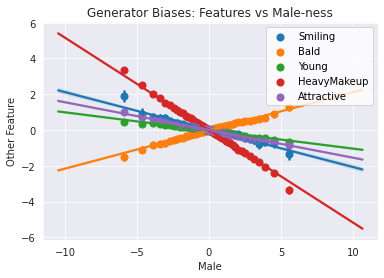

In [9]:
import seaborn as sns
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
    other_indices = feature_names.index(other_feature)
    with sns.axes_style("darkgrid"):
        sns.regplot(
            classification_changes[:, :, target_indices].reshape(-1), 
            classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

In [10]:
from torch.distributions import MultivariateNormal
def covariance_matrix_from_examples(examples):
    """
    Helper function for get_top_covariances to calculate a covariance matrix. 
    Parameter: examples: a list of steps corresponding to samples of shape (2 * grad_steps, n_images, n_features)
    Returns: the (n_features, n_features) covariance matrix from the examples
    """
    # Hint: np.cov will be useful here - note the rowvar argument!
    ### START CODE HERE ###
    return np.cov(examples.reshape(-1, examples.shape[2]), rowvar=False)
    ### END CODE HERE ###
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
samples = MultivariateNormal(mean, covariance).sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1]).numpy()
assert np.all(np.abs(covariance_matrix_from_examples(foo) - covariance.numpy()) < 0.5)
print("covariance_matrix_from_examples works!")

covariance_matrix_from_examples works!


In [11]:
def get_top_magnitude_indices(values):
    """
    Helper function for get_top_covariances to get indices by magnitude. 
    Parameter: values, a list of values as a numpy array of shape (n_values)
    Returns: numpy array of indices sorted from greatest to least by the magnitudes of their corresponding values
    """
    # Hint: This can be done in one or two lines using np.argsort and np.abs!
    ### START CODE HERE ###
    top_indices = np.abs(values).argsort()[::-1]
    ### END CODE HERE ###
    return top_indices
assert get_top_magnitude_indices([3, 2, 1, 0]).tolist() == [0, 1, 2, 3]
assert get_top_magnitude_indices([-2, 0, 1]).tolist() == [0, 2, 1]
print("get_top_magnitude_indices works!")

get_top_magnitude_indices works!


In [12]:
def remove_from_list(indices, index_to_remove):
    """
    Helper function for get_top_covariances to remove an index from an array. 
    Parameter: indices, a list of indices as a numpy array of shape (n_indices)
    Returns: the numpy array of indices in the same order without index_to_remove
    """
    # Hint: There are many ways to do this, but please don't edit the list in-place.
    # If you're not very familiar with array indexing, you may find this page helpful:
    # https://numpy.org/devdocs/reference/arrays.indexing.html (especially boolean indexing)
    ### START CODE HERE ###
    new_indices = np.delete(indices, np.where(indices ==index_to_remove))
    ### END CODE HERE ###
    return new_indices
assert remove_from_list(np.array([3, 2, 1, 0]), 1).tolist() == [3, 2, 0]
print("remove_from_list works!")

remove_from_list works!


In [13]:
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Function for getting the top n covariances: Given a list of classification changes
    and the index of the target feature, returns (1) a list or tensor (numpy or torch) of the indices
    corresponding to the n most covarying factors in terms of absolute covariance
    and (2) a list or tensor (numpy or torch) of the degrees to which they covary.
    Parameters:
        classification_changes: relative changes in classifications of each generated image 
          resulting from optimizing the target feature (see above for a visualization)
        target_index: the index of the target feature, a scalar
        top_n: the top most number of elements to return, default is 10
    '''

    cov_matrix = covariance_matrix_from_examples(classification_changes)
    relevant_indices = get_top_magnitude_indices(cov_matrix[target_index, :])
    relevant_indices = remove_from_list(relevant_indices, target_index)
    relevant_indices = relevant_indices[:top_n]
    highest_covariances = cov_matrix[:, relevant_indices][target_index]
    
    return relevant_indices, highest_covariances

In [14]:
from torch.distributions import MultivariateNormal
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, 5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [5, 4, 2, 11]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1])

relevant_indices, highest_covariances = get_top_covariances(foo, 0, top_n=3)
assert (tuple(relevant_indices) == (3, 1, 2))
assert np.all(np.abs(highest_covariances - [5, 2, -0.5]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 1, top_n=3)
assert (tuple(relevant_indices) == (2, 3, 0))
assert np.all(np.abs(highest_covariances - [5, 4, 2]) < 0.5 )


relevant_indices, highest_covariances = get_top_covariances(foo, 2, top_n=2)
assert (tuple(relevant_indices) == (1, 3))
assert np.all(np.abs(highest_covariances - [5, 2]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 3, top_n=2)
assert (tuple(relevant_indices) == (0, 1))
assert np.all(np.abs(highest_covariances - [5, 4]) < 0.5 )

print("All tests passed")

All tests passed


In [15]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
assert relevant_indices[9] == 34
assert len(relevant_indices) == 10
assert highest_covariances[1] - (-1.2418) < 1e-3
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

[36 18 24 30  0 22 16 38  9 34]
WearingLipstick  -2.950338
HeavyMakeup  -2.703763
NoBeard  -2.557526
Sideburn  2.047919
5oClockShadow  2.005337
Mustache  1.995769
Goatee  1.857525
WearingNecktie  1.582809
BlondHair  -1.239760
WearingEarrings  -1.207334
